## Plotting

In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
from cea.config import Configuration
from cea_energy_hub_optimizer.my_config import MyConfig
from trustParetoFronts.pareto_analysis import ParetoFront

config = MyConfig(Configuration())

# Plot settings
plt.rcParams["font.family"] = "Roboto"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["legend.loc"] = "lower center"
plt.rcParams["legend.frameon"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titley"] = 1.03
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["xtick.major.width"] = 2  # setting the x-axis tick width globally
plt.rcParams["ytick.major.width"] = 2  # setting the y-axis tick width globally
# Set fig size
plt.rcParams["figure.figsize"] = (12, 8)
with_oil = False

In [10]:
def cluster_by_shadow_price_and_reduction_potential(x, y):
    if x < 0.2:
        return 0
    elif y < -100 / 3 * x + 120:
        return 1
    else:
        return 2


if with_oil:
    pareto_fronts_path = os.path.join(
        config.locator.get_optimization_results_folder(),
        "calliope_energy_hub",
        "batch_with_oil",
    )
else:
    pareto_fronts_path = os.path.join(
        config.locator.get_optimization_results_folder(),
        "calliope_energy_hub",
        "batch_without_oil",
    )
# prepare data
zone_path = config.locator.get_zone_geometry()
typology_path = config.locator.get_building_typology()
emission_systems_path = config.locator.get_building_air_conditioning()

zone_gdf: gpd.GeoDataFrame = gpd.read_file(zone_path)
zone_gdf["floor_area"] = zone_gdf.geometry.area
zone_df = pd.DataFrame(zone_gdf).drop(columns="geometry").set_index("Name")
# for dbf_name in os.listdir(config.locator.get_building_properties_folder()):
#     if dbf_name.endswith(".dbf"):
#         print(dbf_name)
#         dbf_path = os.path.join(
#             config.locator.get_building_properties_folder(), dbf_name
#         )
#         dbf_df: pd.DataFrame = gpd.read_file(dbf_path, ignore_geometry=True).set_index(
#             "Name"
#         )
#         dbf_df.columns = [dbf_name[:-4] + "_" + col for col in dbf_df.columns]
#         zone_df = pd.concat([zone_df, dbf_df], axis=1, join="inner")
#         del dbf_df
typology_df: pd.DataFrame = gpd.read_file(
    typology_path, ignore_geometry=True
).set_index("Name")
emission_system_df: pd.DataFrame = gpd.read_file(
    emission_systems_path, ignore_geometry=True
).set_index("Name")
zone_df = pd.concat([zone_df, typology_df, emission_system_df], axis=1, join="inner")
zone_df["area"] = zone_df["floor_area"] * zone_df["floors_ag"]
# delete following columns: 1ST_USE, 1ST_USE_R
# keep_cols = {
#     "air_conditioning.dbf": ["type_hs", "type_ctrl", "type_vent"],
#     "architecture.dbf":

# }
zone_df.drop(
    columns=[
        "height_bg",
        "type_cs",
        "type_dhw",
        "heat_starts",
        "heat_ends",
        "cool_starts",
        "cool_ends",
        "1ST_USE",
        "1ST_USE_R",
        "2ND_USE",
        "2ND_USE_R",
        "3RD_USE",
        "3RD_USE_R",
    ],
    inplace=True,
)
del zone_gdf, typology_df, emission_system_df

df_pareto_dict = {}
for building_name, row in zone_df.iterrows():
    area = float(row["area"])
    csv_name = os.path.join(pareto_fronts_path, f"{building_name}_pareto.csv")
    if not os.path.exists(csv_name):
        zone_df.drop(index=building_name, inplace=True)
        continue
    df_pareto = pd.read_csv(
        csv_name,
        index_col=[0, 1],
    )
    df_pareto_dict[building_name] = df_pareto
    emissions: np.array = df_pareto.loc[building_name, "emission"].values / area
    costs: np.array = df_pareto.loc[building_name, "cost"].values / area
    pf = ParetoFront(np.round(emissions, 3), np.round(costs, 3))
    zone_df.loc[building_name, "shadow_price"] = 1 / pf.slope()
    zone_df.loc[building_name, "pf_curvature"] = pf.curvature()
    zone_df.loc[building_name, "emission_range_abs"] = pf.x_range()
    zone_df.loc[building_name, "cost_range"] = pf.y_range()
    zone_df.loc[building_name, "emission_range_rel"] = pf.x_range(rel=True)
    cluster = cluster_by_shadow_price_and_reduction_potential(
        1 / pf.slope(), pf.x_range(rel=True) * 100
    )
    zone_df.loc[building_name, "cluster"] = cluster

df_pareto_all = pd.concat(df_pareto_dict.values())
demand_color_dict = {
    "demand_space_heating_35": "gold",
    "demand_space_heating_85": "tab:red",
    "demand_hot_water": "tab:orange",
    "demand_electricity": "tab:green",
}

ls_supply_name = df_pareto_all.columns.difference(
    list(demand_color_dict.keys())
    + ["emission", "cost", "demand_space_heating_60", "demand_space_cooling"]
)
if not with_oil:
    ls_supply_name = ls_supply_name.difference(
        ["oil", "oil_boiler_large", "oil_boiler_middle", "oil_boiler_small"]
    )
df_pareto_all = df_pareto_all.merge(zone_df, left_on="building", right_index=True)

(0.1459238902307785, 9.534611735399281)


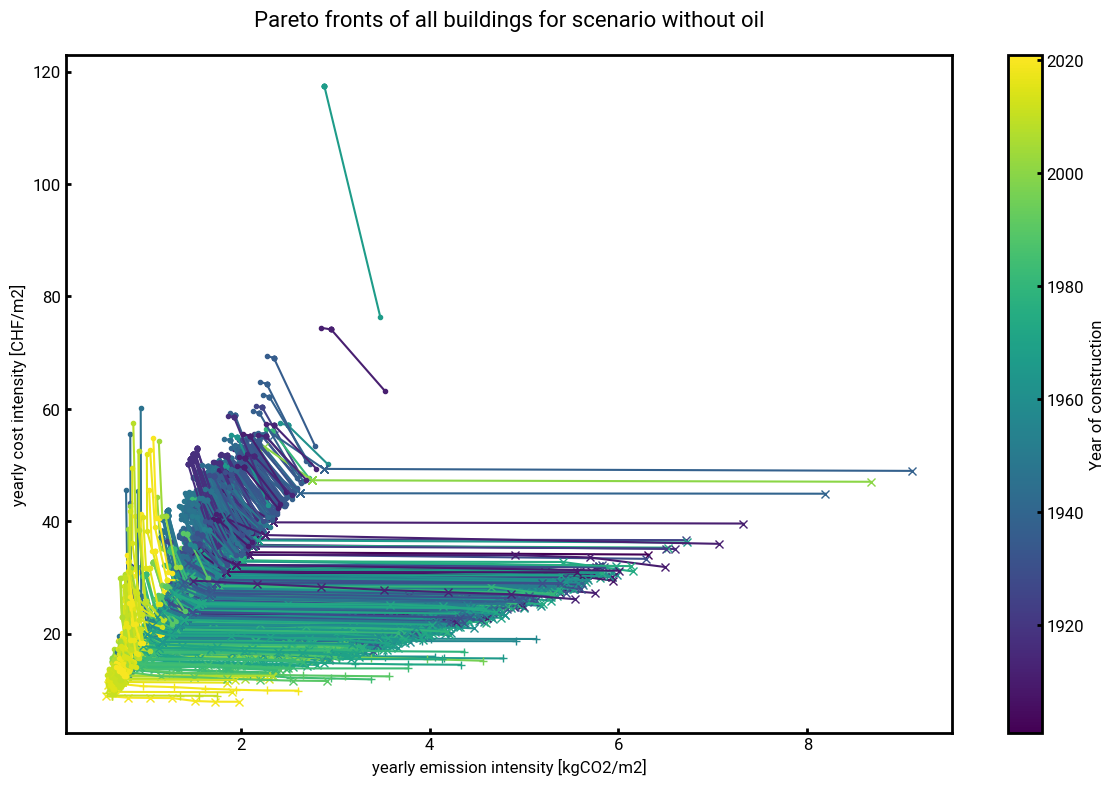

In [11]:
cluster_markers = {
    0: ".",
    1: "x",
    2: "+",
}
fig1, ax1 = plt.subplots()
year_min = df_pareto_all["YEAR"].min()
year_max = df_pareto_all["YEAR"].max()
year_norm = mcolors.Normalize(vmin=year_min, vmax=year_max)
colormap = plt.get_cmap("viridis")  # type: ignore
for building_name in df_pareto_all.index.get_level_values(0).unique():
    df_pareto = df_pareto_all.loc[building_name]
    # pareto front has two levels of index, the first one is the building name and second one is the pareto front number starting from 0
    emissions = df_pareto["emission"].values
    costs = df_pareto["cost"].values
    area = df_pareto[
        "area"
    ].mean()  # area is the same for all pareto fronts of the same building
    cluster = df_pareto["cluster"].iloc[0]
    ax1.plot(
        emissions / area,
        costs / area,
        label=building_name,
        marker=cluster_markers[cluster],
        color=colormap(year_norm(zone_df["YEAR"].loc[building_name])),
    )
cbar1 = fig1.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=ax1, orientation="vertical")  # type: ignore
cbar1.set_label("Year of construction")
ax1.set_xlabel("yearly emission intensity [kgCO2/m2]")
ax1.set_ylabel("yearly cost intensity [CHF/m2]")
print(ax1.get_xlim())
if with_oil:
    ax1.set_title("Pareto fronts of all buildings for scenario with oil")
else:
    ax1.set_title("Pareto fronts of all buildings for scenario without oil")
fig1.tight_layout()

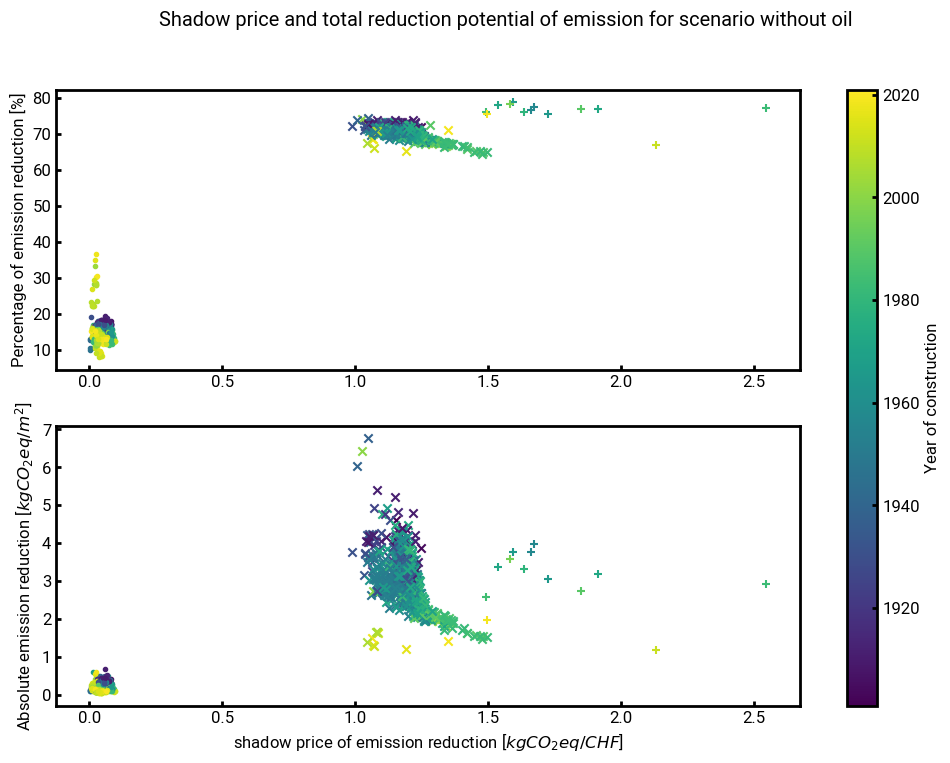

In [12]:
fig2, axes = plt.subplots(2, 1)
for idx, ax in enumerate(axes):
    for building_name in df_pareto_all.index.get_level_values(0).unique():
        df_pareto = df_pareto_all.loc[building_name]
        emissions = df_pareto["emission"].values
        costs = df_pareto["cost"].values
        area = df_pareto["area"].iloc[
            0
        ]  # area is the same for all pareto fronts of the same building
        cluster = df_pareto["cluster"].iloc[0]
        dx = df_pareto["shadow_price"].iloc[0]
        if idx == 0:  # plotting relative emission reduction
            dy = df_pareto["emission_range_rel"].iloc[0] * 100
            ax.set_ylabel("Percentage of emission reduction [%]")
        else:  # idx=1, second subplot, plotting absolute emission reduction
            dy = df_pareto["emission_range_abs"].iloc[0]
            ax.set_ylabel("Absolute emission reduction [$kgCO_2eq/m^2$]")

        building_year = df_pareto["YEAR"].iloc[0]
        building_color = colormap(year_norm(building_year))
        ax.scatter(dx, dy, marker=cluster_markers[cluster], color=building_color)

axes[0].sharex(axes[1])
axes[1].set_xlabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")
cbar2 = fig2.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=axes, orientation="vertical")  # type: ignore
cbar2.set_label("Year of construction")
if with_oil:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario with oil"
    )
else:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario without oil"
    )

In [ ]:
from trustParetoFronts.pareto_front_plots import tech_size_boxplot

if with_oil:
    title_3 = "Pareto fronts of all buildings for scenario with oil"
else:
    title_3 = "Pareto fronts of all buildings for scenario without oil"
tech_size_boxplot(
    df_pareto_all,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig=title_3,
    figsize=(40, 10),
    width_ratios=(8, 1),
)

df_pareto_0 = df_pareto_all[df_pareto_all["cluster"] == 0]
df_pareto_1 = df_pareto_all[df_pareto_all["cluster"] == 1]
df_pareto_2 = df_pareto_all[df_pareto_all["cluster"] == 2]

tech_size_boxplot(
    df_pareto_0,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Pareto fronts of cluster 0",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

tech_size_boxplot(
    df_pareto_1,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Pareto fronts of cluster 1",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

tech_size_boxplot(
    df_pareto_2,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Pareto fronts of cluster 2",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

## explain clustering in fig2

In [14]:
from sklearn.preprocessing import LabelEncoder

data = zone_df.copy()
label_encoders = {}
for col in data.select_dtypes(include="object").columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

x = data.drop(
    columns=[
        "shadow_price",
        "pf_curvature",
        "emission_range_abs",
        "cost_range",
        "emission_range_rel",
        "cluster",
    ]
)
y = data["cluster"]

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)
clf = RandomForestClassifier(random_state=42)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       201
         1.0       0.93      0.97      0.95       287
         2.0       0.50      0.12      0.20         8

    accuracy                           0.94       496
   macro avg       0.79      0.67      0.70       496
weighted avg       0.93      0.94      0.93       496



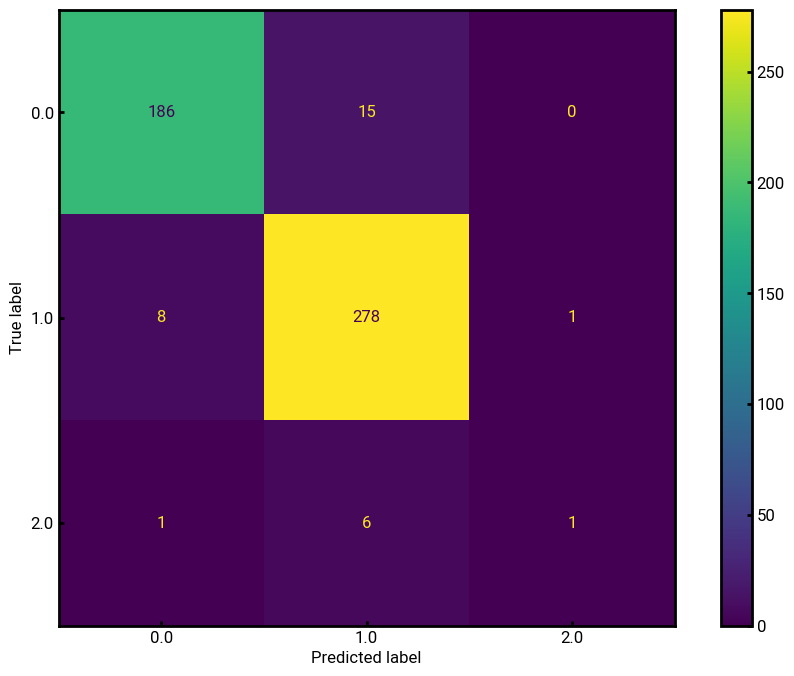

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
plt.show()

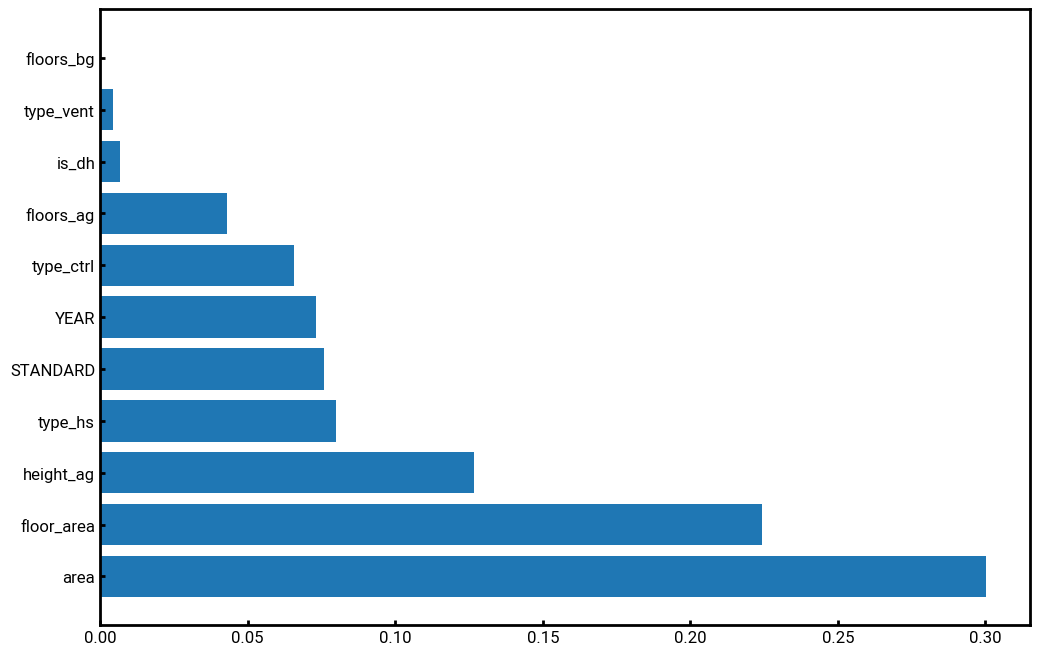

In [16]:
feature_importance = pd.DataFrame(
    {"feature": x.columns, "importance": clf.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance["feature"], feature_importance["importance"])
plt.show()

In [17]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, x, y, cv=5, scoring="accuracy")
print(f"Cv scores mean: {cv_scores.mean():.2f}, std: {cv_scores.std():.2f}")

Cv scores mean: 0.94, std: 0.02


### explain linear distribution of second cluster in fig2

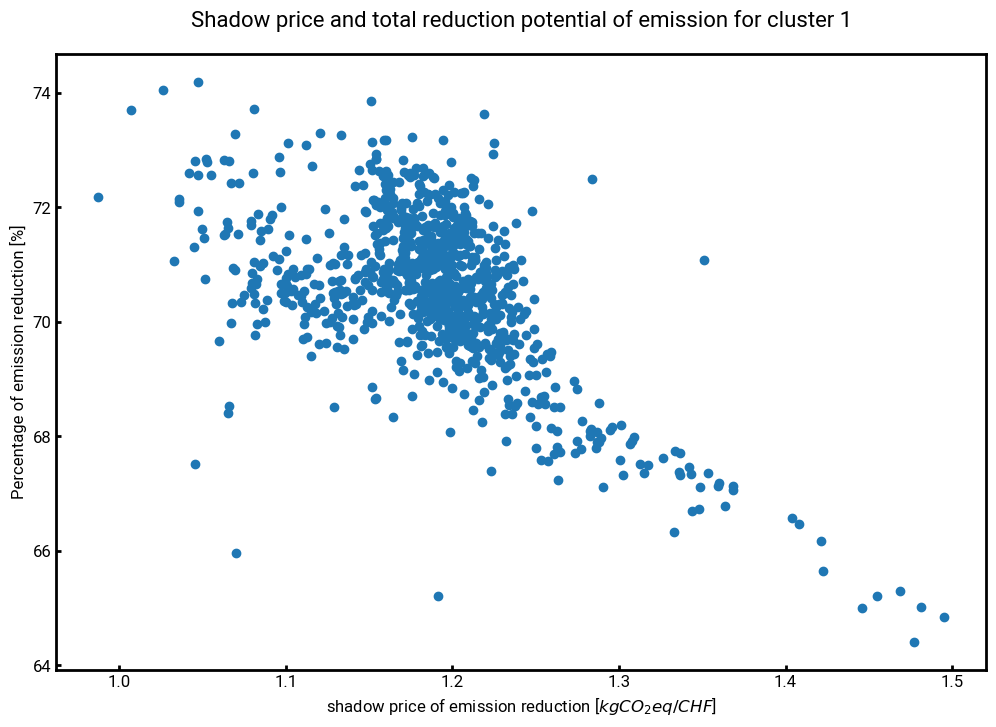

In [19]:
cluster_1 = zone_df[zone_df["cluster"] == 1]
# plot the relative emission reduction potential vs shadow price
fig, ax = plt.subplots()
ax.scatter(cluster_1["shadow_price"], cluster_1["emission_range_rel"] * 100)
ax.set_xlabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")
ax.set_ylabel("Percentage of emission reduction [%]")
ax.set_title("Shadow price and total reduction potential of emission for cluster 1")
plt.show()

0.6016814696132691
       feature   coefficient
8    type_ctrl  5.096315e-03
2    height_ag  4.557444e-03
9    type_vent  3.069780e-03
7      type_hs  2.026535e-03
10        area  1.500092e-05
1    floors_bg -3.960997e-16
3   floor_area -1.032173e-04
6         YEAR -1.488403e-04
4        is_dh -1.829329e-03
5     STANDARD -4.817133e-03
0    floors_ag -1.688523e-02


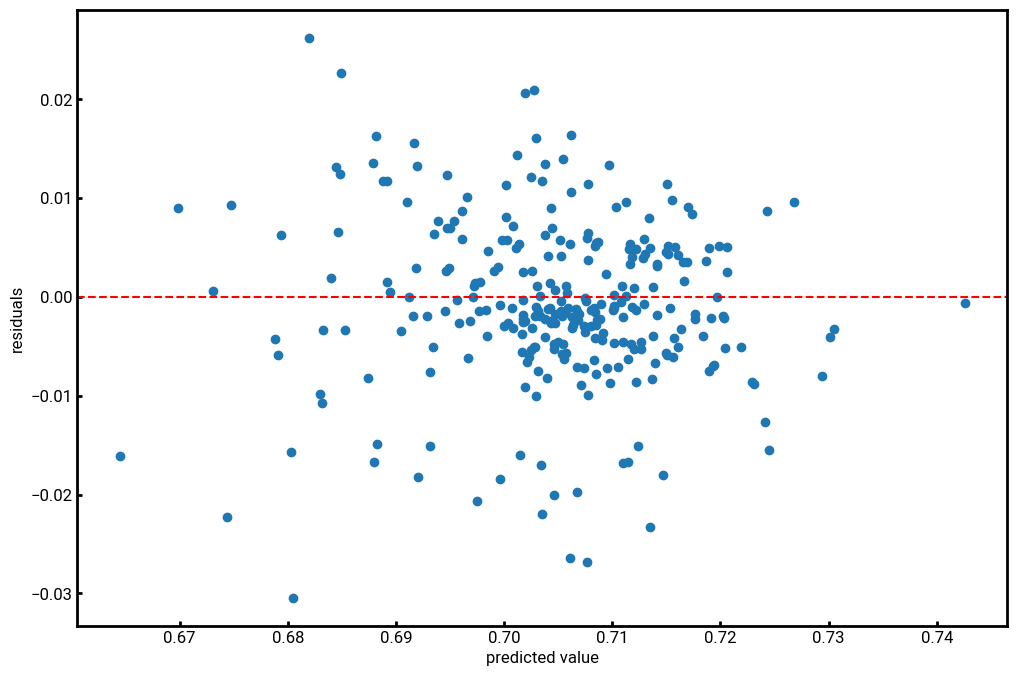

Cv scores mean: 0.56, std: 0.12


In [ ]:
from sklearn.preprocessing import OneHotEncoder

cluster_1_encoded = cluster_1.copy()
enc = OneHotEncoder()
for col in cluster_1.select_dtypes(include="object").columns:
    cluster_1_encoded[col] = label_encoders[col].transform(cluster_1[col])
x = cluster_1_encoded.drop(
    columns=[
        "shadow_price",
        "pf_curvature",
        "emission_range_abs",
        "cost_range",
        "emission_range_rel",
        "cluster",
    ]
)
y1 = cluster_1_encoded["emission_range_rel"]
y2 = cluster_1_encoded["shadow_price"]

from sklearn.linear_model import LinearRegression

x_train, x_test, y1_train, y1_test = train_test_split(
    x, y1, test_size=0.3, random_state=42
)
model = LinearRegression()
model.fit(x_train, y1_train)
y1_pred = model.predict(x_test)
print(model.score(x_test, y1_test))

coeff_y1 = pd.DataFrame({"feature": x.columns, "coefficient": model.coef_}).sort_values(
    "coefficient", ascending=False
)
print(coeff_y1)

residuals = y1_test - y1_pred
fig, ax = plt.subplots()
ax.scatter(y1_pred, residuals)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("predicted value")
ax.set_ylabel("residuals")
plt.show()

cv_scores = cross_val_score(model, x, y1, cv=5, scoring="r2")
print(f"Cv scores mean: {cv_scores.mean():.2f}, std: {cv_scores.std():.2f}")

0.6360232758418938
       feature   coefficient
9    type_vent  1.303323e-01
0    floors_ag  4.882624e-02
5     STANDARD  2.728732e-02
4        is_dh  7.318245e-03
3   floor_area  8.017619e-04
1    floors_bg -2.167201e-14
10        area -1.048600e-04
6         YEAR -2.481740e-04
2    height_ag -2.735795e-03
8    type_ctrl -5.699815e-02
7      type_hs -1.873304e-01


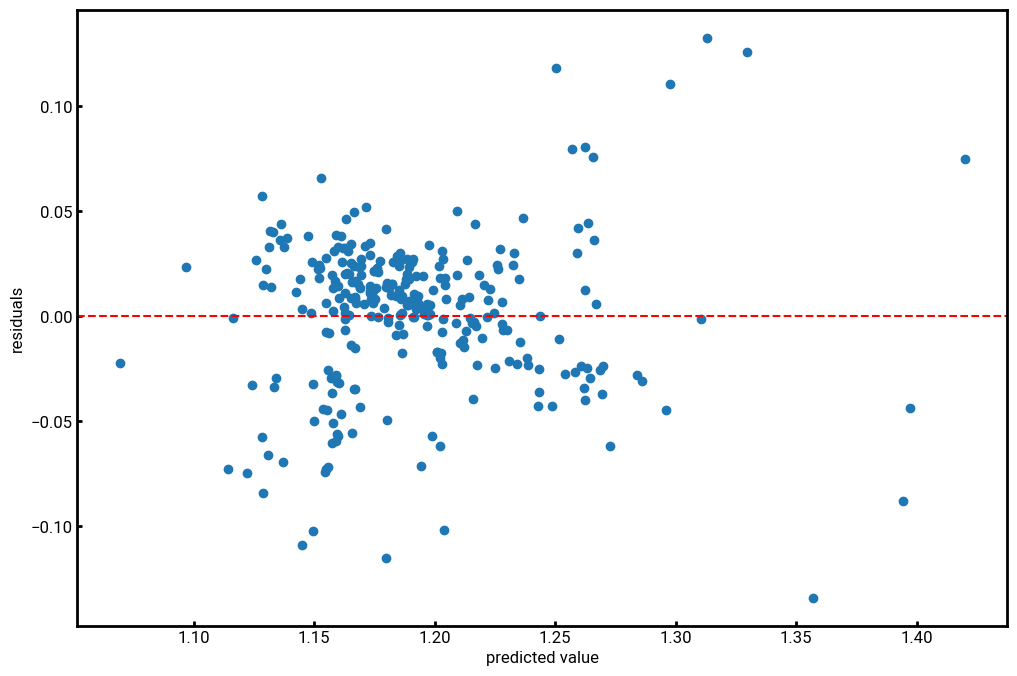

Cv scores mean: 0.55, std: 0.06


In [ ]:
x_train, x_test, y2_train, y2_test = train_test_split(
    x, y2, test_size=0.3, random_state=42
)
model = LinearRegression()
model.fit(x_train, y2_train)
y2_pred = model.predict(x_test)
print(model.score(x_test, y2_test))

coeff_y2 = pd.DataFrame({"feature": x.columns, "coefficient": model.coef_}).sort_values(
    "coefficient", ascending=False
)
print(coeff_y2)

residuals = y2_test - y2_pred
fig, ax = plt.subplots()
ax.scatter(y2_pred, residuals)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("predicted value")
ax.set_ylabel("residuals")
plt.show()

cv_scores = cross_val_score(model, x, y2, cv=5, scoring="r2")
print(f"Cv scores mean: {cv_scores.mean():.2f}, std: {cv_scores.std():.2f}")

### explain distribution of second cluster in fig2 using tree-based model

0.8872463226740728
Mean squared error: 0.00, R2 score: 0.89


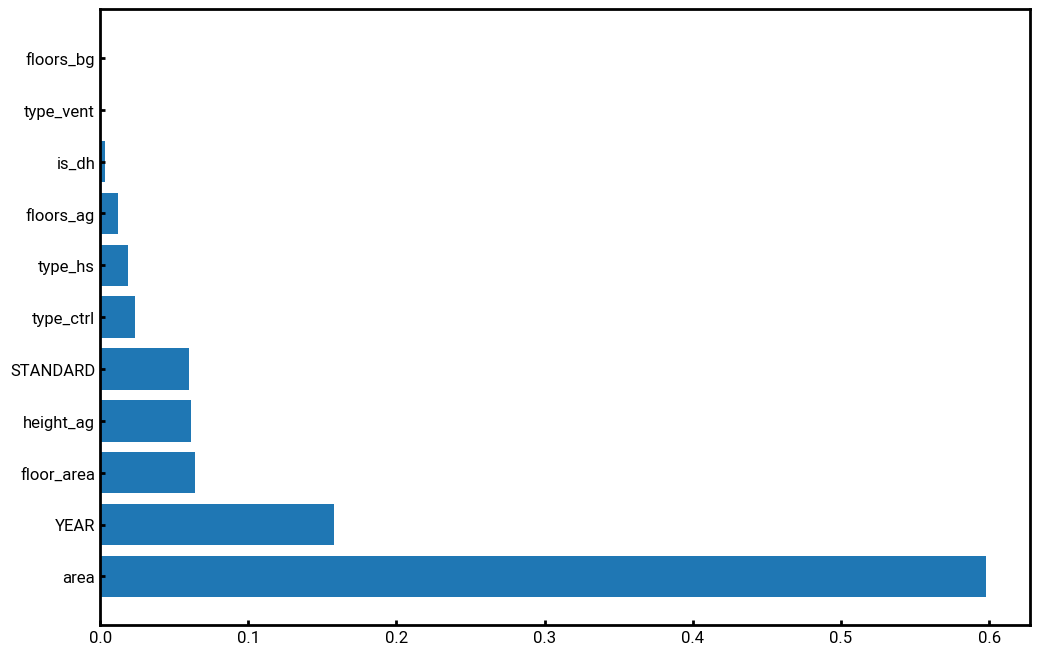

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

cluster_1_tree = cluster_1.copy()
for col in cluster_1_tree.select_dtypes(include="object").columns:
    cluster_1_tree[col] = label_encoders[col].transform(cluster_1_tree[col])


x = cluster_1_tree.drop(
    columns=[
        "shadow_price",
        "pf_curvature",
        "emission_range_abs",
        "cost_range",
        "emission_range_rel",
        "cluster",
    ]
)
y1 = cluster_1_tree["shadow_price"]
y2 = cluster_1_tree["emission_range_rel"]

x1_train, x1_test, y1_train, y1_test = train_test_split(
    x, y1, test_size=0.3, random_state=42
)
model = RandomForestRegressor(random_state=42)
model.fit(x1_train, y1_train)
y1_pred = model.predict(x1_test)
print(model.score(x1_test, y1_test))

mse = mean_squared_error(y1_test, y1_pred)
r2 = r2_score(y1_test, y1_pred)
print(f"Mean squared error: {mse:.2f}, R2 score: {r2:.2f}")

feature_importance = pd.DataFrame(
    {"feature": x.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance["feature"], feature_importance["importance"])
plt.show()

0.7514877329703724
Mean squared error: 0.00, R2 score: 0.75


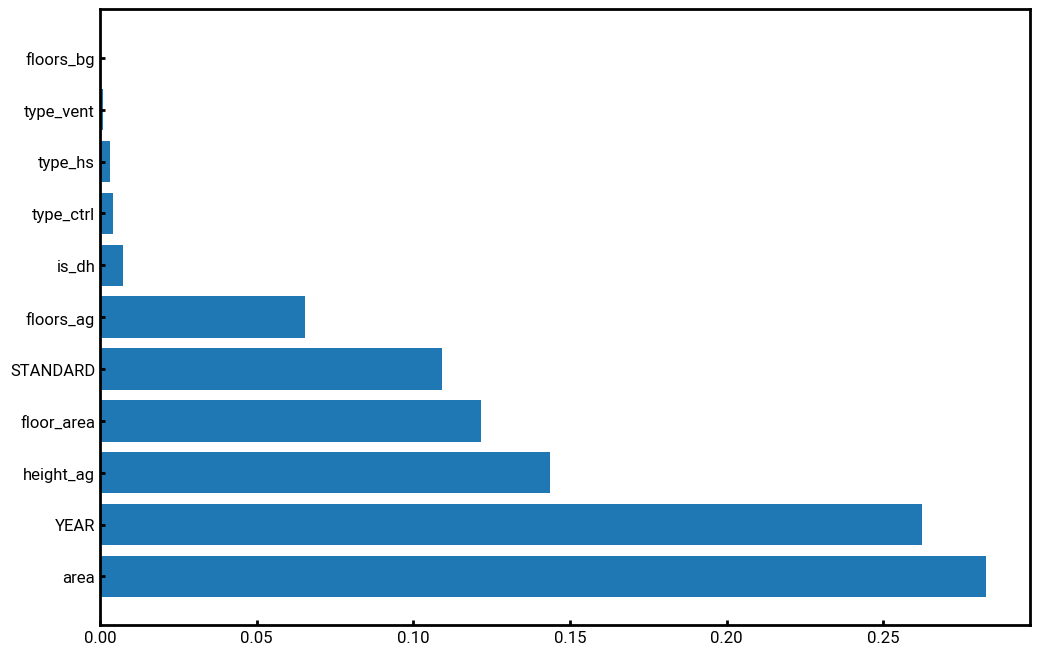

In [ ]:
x2_train, x2_test, y2_train, y2_test = train_test_split(
    x, y2, test_size=0.3, random_state=42
)
model = RandomForestRegressor(random_state=42)
model.fit(x2_train, y2_train)
y2_pred = model.predict(x2_test)
print(model.score(x2_test, y2_test))

mse = mean_squared_error(y2_test, y2_pred)
r2 = r2_score(y2_test, y2_pred)
print(f"Mean squared error: {mse:.2f}, R2 score: {r2:.2f}")

feature_importance = pd.DataFrame(
    {"feature": x.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance["feature"], feature_importance["importance"])
plt.show()

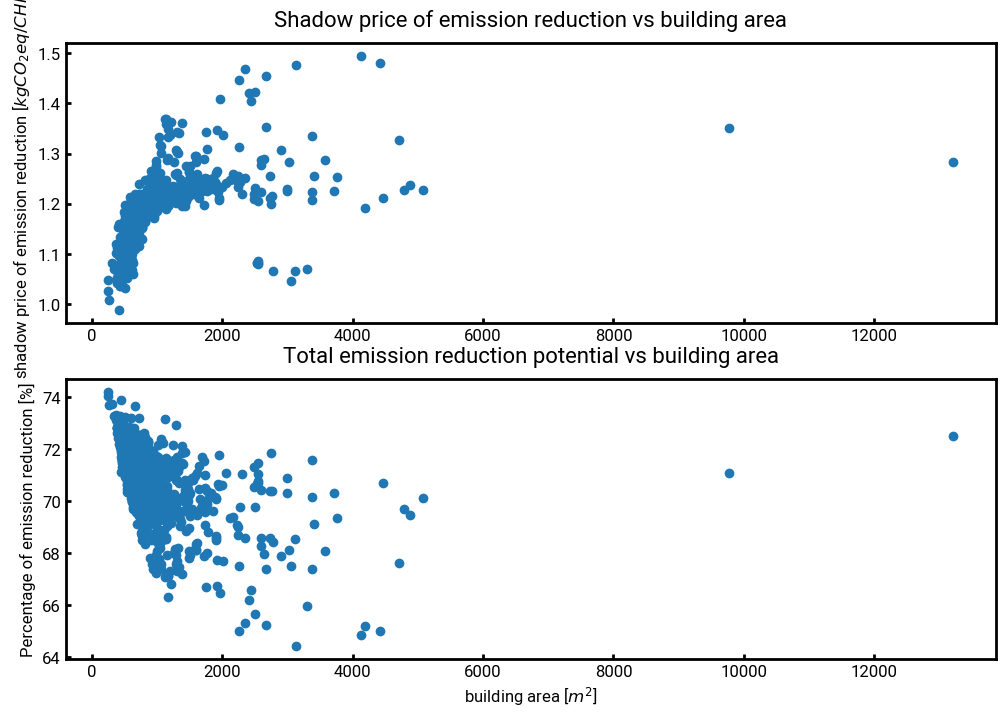

In [ ]:
# plot both the shadow price and the relative emission reduction potential against building area
fig, axes = plt.subplots(2, 1)
axes[0].scatter(cluster_1["area"], cluster_1["shadow_price"])
axes[0].set_ylabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")
axes[0].set_title("Shadow price of emission reduction vs building area")
axes[1].scatter(cluster_1["area"], cluster_1["emission_range_rel"] * 100)
axes[1].set_ylabel("Percentage of emission reduction [%]")
axes[1].set_xlabel("building area [$m^2$]")
axes[1].set_title("Total emission reduction potential vs building area")
plt.show()